# Image Classification Using CNN

In this notebook, we will implement and train a Convolutional Neural Network (CNN) from scratch, aiming to develop a robust traffic sign recognition system from the GTSRB - German Traffic Sign Recognition Benchmark dataset. We will build and use a CNN architecture and apply essential regularization techniques such as batch normalization, dropout, and data augmentations. Combining these powerful techniques, we aim to create a highly accurate model that can recognize and classify traffic signs effectively.


<img src="https://opencv.org/wp-content/uploads/2023/05/c2_w1_image_classification_w_CNN_cover.png">

The German Traffic Sign Recognition Benchmark (GTSRB) dataset is widely used in computer vision and machine learning. The dataset consists of images of various traffic signs commonly found in Germany, including speed limit signs, yield signs, stop signs, and many others. These images are captured under different lighting conditions, weather conditions, and viewpoints, making it challenging for algorithms to accurately classify and recognize the signs. The classification dataset contains **43 classes of German traffic signs.** The entire dataset (Train and Test) contains over 50,000 images. To evaluate how well the model generalizes, we will use the original test dataset, which contains 12,630 samples.

## Table of Contents

*   [1 Download and Extract the Dataset](#1-Download-and-Extract-the-Dataset)
*   [2 Dataset and Training Configuration](#2-Dataset-and-Training-Configuration)
*   [3 Prepare GTSRB Dataset](#3-Prepare-GTSRB-Dataset)
*   [4 Training and Validation helper function](#4-Training-and-Validation-helper-function)
*   [5 Main Function for Training](#5-Main-Function-for-Training)
*   [6 Creating CNN Model From Scratch](#6-Creating-CNN-Model-From-Scratch)
*   [7 Train the Model](#7-Train-the-Model)
*   [8 Perform Inference](#8-Perform-Inference)
*   [9 Conclusion](#9-Conclusion)
*   [Exercise](#Exercise)

In [ ]:
!nvidia-smi

Tue May 30 05:59:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# # Install the following packages and restart the kernel.
# !pip install -qU torchmetrics livelossplot torchinfo tqdm

In [ ]:
import os
import gc
import warnings
from zipfile import ZipFile
from dataclasses import dataclass
from urllib.request import urlretrieve
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torchvision.ops import Conv2dNormActivation

from tqdm import tqdm
from torchinfo import summary
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

# For plotting training and validation metrics during training.
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot, ExtremaPrinter

%matplotlib inline
warnings.filterwarnings(action='ignore', category=UserWarning)

# Text formatting
BOLD = "\033[1m"
END = "\033[0m"

In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def get_default_device():
    gpu_available = torch.cuda.is_available()
    return torch.device('cuda' if gpu_available else 'cpu'), gpu_available

## 1 Download and Extract the Dataset

<img src="https://opencv.org/wp-content/uploads/2023/05/c2_w1_image_classification_w_CNN_dataset-cover.jpg">

The German Traffic Sign Recognition Benchmark ([GTSRB](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)) is a well-known classification dataset that contains German traffic signs from 43 classes. The entire dataset (Train and Test) contains over 50000 images. The original "Train" set alone contains over 39209 images. This set was split into two sets of "training" and validation in a 80:20 split.

For this notebook, we will be using the split dataset, with each split containing:

```bash
1. training   - 31367 images
2. validation - 7842 images
3. testing    - 12630 images.
```

In [ ]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [ ]:
URL = r"https://www.dropbox.com/s/bdr2qu838lr59om/m1_03_image_classification_CNN_GTSRB.zip?dl=1"

dataset_path   = os.path.join(os.getcwd(), "w1_image_classification_CNN_GTSRB")
asset_zip_path = os.path.join(os.getcwd(), "w1_image_classification_CNN_GTSRB.zip")

# Download if dataset does not exists.
if not os.path.exists(dataset_path):
    download_and_unzip(URL, asset_zip_path)
    # shutil.rmtree(asset_zip_path) # Remove the ZIP file to free storage space.

## 2 Dataset and Training Configuration

Here we can use the Python dataclasses module to create two classes to configure data and training hyperparameters conveniently

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    HEIGHT:        int = 28
    WIDTH:         int = 28
    CHANNELS:      int = 3
    NUM_CLASSES:   int = 43

    DATA_ROOT_TRAIN: str = os.path.join(dataset_path, "training")
    DATA_ROOT_VALID: str = os.path.join(dataset_path, "validation")
    DATA_ROOT_TEST:  str = os.path.join(dataset_path, "testing")


@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 64
    NUM_EPOCHS:      int = 20
    LEARNING_RATE: float = 0.001
    NUM_WORKERS:     int = os.cpu_count()
    CHECKPOINT_DIR:  str = os.path.join('model_checkpoint', 'CNN_Scratch')

The following is the mapping of the class id's to their actual class names. We won't be using this dictionary during visualization as it overcrowds and overlaps the spaces between each image during visualization. However, you may choose to use it if needed.

In [ ]:
classes = {
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)',
    2:'Speed limit (50km/h)',
    3:'Speed limit (60km/h)',
    4:'Speed limit (70km/h)',
    5:'Speed limit (80km/h)',
    6:'End of speed limit (80km/h)',
    7:'Speed limit (100km/h)',
    8:'Speed limit (120km/h)',
    9:'No passing',
    10:'No passing veh over 3.5 tons',
    11:'Right-of-way at intersection',
    12:'Priority road',
    13:'Yield',
    14:'Stop',
    15:'No vehicles',
    16:'Veh > 3.5 tons prohibited',
    17:'No entry',
    18:'General caution',
    19:'Dangerous curve left',
    20:'Dangerous curve right',
    21:'Double curve',
    22:'Bumpy road',
    23:'Slippery road',
    24:'Road narrows on the right',
    25:'Road work',
    26:'Traffic signals',
    27:'Pedestrians',
    28:'Children crossing',
    29:'Bicycles crossing',
    30:'Beware of ice/snow',
    31:'Wild animals crossing',
    32:'End speed + passing limits',
    33:'Turn right ahead',
    34:'Turn left ahead',
    35:'Ahead only',
    36:'Go straight or right',
    37:'Go straight or left',
    38:'Keep right',
    39:'Keep left',
    40:'Roundabout mandatory',
    41:'End of no passing',
    42:'End no passing veh > 3.5 tons'
}

## 3 Prepare GTSRB Dataset

For this notebok, the prepared dataset that is downloaded has the following structure:

```html
w1_image_classification_CNN_GTSRB
├───testing
│   ├───0
│   ├───1
│   ├───2
│   ...
│   ...
│   ├───42
│   └───43
│
├───training
│   ├───0
│   ├───1
│   ├───2
│   ...
│   ...
│   ├───42
│   └───43
│
└───validation
    ├───0
    ├───1
    ├───2
    ...
    ...
    ├───42
    └───43
```

When a dataset has the following structure i.e., each split is a separate folder and classes within a split also have a folder structure then we can use the  `torchvision.datasets.ImageFolder` class to load all the images and classes using a single line of code. For eg.

```python
# Loading the training set
train_dataset = datasets.ImageFolder("path\to\training\set")
```

For this notebook, we have split our transformation function into two:

1. `get_preprocess_transforms(...)` is used to apply the resizing and rescaling operation.

2. `get_common_transforms(...)` is used when we have calculated the mean and std. dev. statistic of the training set adds the normalization transform on top of the preprocessing transforms defined in `get_preprocess_transforms(...)`.

In [ ]:
def get_preprocess_transforms(resize_to=(28, 28)):
    # We will only apply pre-processing transformations to the train and valid dataset.
    preprocessing_transforms = transforms.Compose(
        [
            # Resize image.
            transforms.Resize(resize_to),

            # Re-scale image tensor values between 0-1. image_tensor /= 255
            transforms.ToTensor(),
        ]
    )
    return preprocessing_transforms

In [ ]:
def get_common_transforms(*, resize_to, mean, std):
    preprocess = get_preprocess_transforms(resize_to=resize_to)

    common_transforms = transforms.Compose([
        # Apply the usual pre-processing transforms.
        preprocess,

        # Normalize image by Subtracting mean and divide by std. dev. of the training dataset.
        transforms.Normalize(mean, std)
    ])

    return common_transforms

Before creating the dataloaders, like in the last notebook, we compute the mean and std of the training set. Previously, the dataset was small and was able to fit in the memory. However that may not  be the case everytime.

The dataset we are using in this notebook lies on disk and to calculate the statistics we first need to load images (one by one or in batches) and calculate statistics of each batch first to compute the mean and std. dev. of the entire training dataset.

To help with this, we have defined a `get_mean_std(...)` helper function.

The function:

1. Fetches the pre-processing transforms.
2. Intializes training dataset and create a dataloader.
3. Loops over the train dataloader and calculates per batch mean $E(\text{batch}) = E[x]$ and squared mean $E(\text{batch}^2) = E[x^2]$
4. Calcuates $\text{mean} = E(X) = E[E[x_1], E[x_2], ...]$ of the entire dataset.
5. With the help of mean, calculates variance $\text{var}[X] = E[X^2] - E[X]^2$ of the entire dataset.
6. Calcualtes standard deviation from the variance.

In [ ]:
def get_mean_std(data_root, resize_to=(28, 28), batch_size=128, num_workers=4, generator=None):

    # Initialize loader.
    pre_transforms = get_preprocess_transforms(resize_to=resize_to)
    train_dataset  = datasets.ImageFolder(data_root, transform=pre_transforms)
    train_loader   = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Contants to hold intermediate mean and mean_sqrd values.
    batch_mean = torch.zeros(DatasetConfig.CHANNELS)
    batch_mean_sqrd = torch.zeros(DatasetConfig.CHANNELS)

    for batch_data, _ in tqdm(iterable=train_loader, ascii=True, total=len(train_loader), desc="Computing MEAN & STD"):
        batch_mean += batch_data.mean(dim=(0, 2, 3)) # E[batch_i]
        batch_mean_sqrd += (batch_data ** 2).mean(dim=(0, 2, 3)) #  E[batch_i**2]

    # E[dataset] = E[E[batch_1], E[batch_2], ...]
    mean = batch_mean / len(train_loader)

    # var[X] = E[X**2] - E[X]**2

    # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
    # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2

    var = (batch_mean_sqrd / len(train_loader)) - (mean ** 2)

    std = var ** 0.5
    print('Mean: {}, Std: {}'.format(mean, std))

    return mean, std

The `get_data(...)` method is almost similar to the previous notebook. The minor change over here is we first calculate the dataset statistics and we also have a choice to apply data augmentation to the tranining set.

In [ ]:
def get_data(resize_to=(32, 32), batch_size=32, pin_memory=False, num_workers=0, data_augmentation=False):

    try:
        # Check if "MEAN" and "STD. DEV." have already been calculated and available
        # in the DatasetConfig.
        MEAN = getattr(DatasetConfig, "MEAN")
        STD  = getattr(DatasetConfig, "STD")

    except AttributeError:

        # If not, calculate the MEAN and STD. DEV. on the training set.
        MEAN, STD = get_mean_std(DatasetConfig.DATA_ROOT_TRAIN, resize_to=resize_to, num_workers=2)

        # Set the calculated MEAN and STD as an class attribute of the DatasetConfig class.
        DatasetConfig.MEAN = MEAN
        DatasetConfig.STD  = STD

    finally:

        # Load the commonly used transforms: resize, re-scale, normalize.
        common_transforms = get_common_transforms(resize_to=resize_to, mean=MEAN, std=STD)

    if data_augmentation:
        # As this dataset already contains images with varied lightning conditions,
        # We are only using a one transformation "RandomAffine" to apply some geometric transformations.
        # We have not applied flipping transformation as its possible that it will change the meaning of the sign.
        train_transforms = transforms.Compose([
            common_transforms,
            transforms.RandomAffine(degrees=(-0.1, 0.1), translate=(0.1, 0.1), scale=(0.95, 1.05)),
        ])

    else:
        train_transforms = common_transforms

    # Initialize train dataloader
    train_dataset = datasets.ImageFolder(DatasetConfig.DATA_ROOT_TRAIN, transform=train_transforms)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=pin_memory, shuffle=True, num_workers=num_workers)

    # Initialize valid dataloader
    valid_dataset = datasets.ImageFolder(DatasetConfig.DATA_ROOT_VALID, transform=common_transforms)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=pin_memory, shuffle=False, num_workers=num_workers)

    # Initialize test dataloader
    test_dataset = datasets.ImageFolder(DatasetConfig.DATA_ROOT_TEST, transform=common_transforms)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=pin_memory, shuffle=True, num_workers=num_workers)

    print(f"Number of images :: Training: {len(train_dataset)}, Validation: {len(valid_dataset)}, Testing: {len(test_dataset)}")
    return train_loader, valid_loader, test_loader

### 3.1 Display Sample Images

In [ ]:
# This function is used for reversing the Normalization step performed during image preprocessing.
# Note the mean and std values must match the ones used.


def denormalize(tensors, *, mean, std):
    """Denormalizes image tensors using mean and std provided
    and clip values between 0 and 1"""

    for c in range(DatasetConfig.CHANNELS):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors, min=0.0, max=1.0)

In [ ]:
def visualize_samples(loader):

    plt.figure(figsize=(7, 7))

    for X, y in loader:

        images = denormalize(X, mean=DatasetConfig.MEAN, std=DatasetConfig.STD).permute(0, 2, 3, 1).numpy()
        target = y.numpy()

        for i in range(1, 37):
            plt.subplot(6, 6, i)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[i])
            plt.xlabel(f"{target[i]}", fontsize=12)

        plt.suptitle('Dataset Samples', fontsize=18)
        plt.tight_layout()
        plt.show()
        plt.close()

        break

    return

Computing MEAN & STD: 100%|##########| 246/246 [00:07<00:00, 31.13it/s]


Mean: tensor([0.3416, 0.3132, 0.3223]), Std: tensor([0.2716, 0.2598, 0.2659])
Number of images :: Training: 31367, Validation: 7842, Testing: 12630


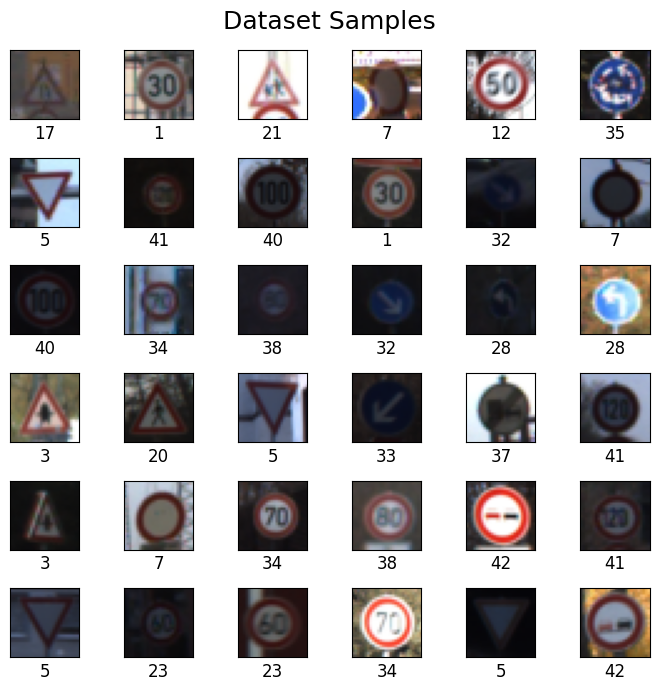

In [ ]:
train_loader, valid_loader, test_loader = get_data(resize_to=(DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
                                                   batch_size=TrainingConfig.BATCH_SIZE
                                                  )

visualize_samples(train_loader)

## 4 Training and Validation helper function

Next we are defining the `train_one_epoch` and `evaluate` function. The function definitions are the same as we did in the previous notebook.


1. `train_one_epoch(...)` - This function is used to perform 1 epoch of training where parameters of the model are updated.
2. `evaluate(...)` - This function is used to evaluate how good the model performs on unseen images.

Both the `train_one_epoch(...)` and `evaluate(...)` functions utilize the `tqdm` package to display a progress bar during training and evaluation stages, which visually represents the progress of the training and evaluation loops. The bar displays the running loss and accuracy of the model.

### 4.1 Training Function

In [ ]:
def train_one_epoch(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    num_classes: int,
    epoch_idx: int,
    total_epochs: int,
):
    # Set model to training mode.
    model.train()

    # Torchmetrics classes used to record and calulate loss and accuracy
    loss_record = MeanMetric()
    acc_record  = MulticlassAccuracy(num_classes=num_classes, average="micro")

    loader_len = len(loader)

    with tqdm(total=loader_len, ncols=122, ascii=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch_idx}/{total_epochs}")

        for data, target in loader:
            tq.update(1)

            # Send data and target to GPU device if available.
            data   = data.to(device)
            target = target.to(device)

            # Reset parameters gradient to zero.
            optimizer.zero_grad()

            # Perform forward pass through the model.
            logits = model(data)

            # Calculate Cross-entropy loss.
            loss = F.cross_entropy(logits, target)

            # Find gradients w.r.t training parameters.
            loss.backward()

            # Update parameters using gradients.
            optimizer.step()

            # Record loss.
            loss_record.update(loss.detach().cpu(), weight=data.shape[0])

            # Get the index of node with max score.
            pred = torch.argmax(logits, dim=1)

            # Calculate and record accuracy.
            acc_record.update(pred.cpu(), target.cpu())

            # Update progress bar description with running mean and accuracy values.
            tq.set_postfix_str(s=f"Loss: {loss_record.compute():.4f}, Acc: {acc_record.compute():.4f}")

    # Get final loss and accuracy.
    # The values are the same as the one displayed for the final iteration.
    epoch_loss = loss_record.compute()
    epoch_acc  = acc_record.compute()

    return epoch_loss.item(), epoch_acc.item()

### 4.2 Evaluation Function

In [ ]:
def evaluate(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    num_classes: int,
    epoch_idx: int,
    total_epochs: int,
    validation: bool = True
):

    # Set model to evaluation mode.
    model.eval()

    loss_record = MeanMetric()
    acc_record = MulticlassAccuracy(num_classes=num_classes, average="micro")

    loader_len = len(loader)

    with tqdm(total=loader_len, ncols=122, ascii=True) as tq:
        tq.set_description(f"{'Valid' if validation else 'Test'} :: Epoch: {epoch_idx}/{total_epochs}")

        for data, target in loader:
            tq.update(1)

            # Send data and target to GPU device if available.
            data     = data.to(device)
            target = target.to(device)

            with torch.no_grad():
                # Perform forward pass through the model.
                logits = model(data)

            # Calculate Cross-entropy loss.
            loss = F.cross_entropy(logits, target)

            # Record loss.
            loss_record.update(loss.cpu(), weight=data.shape[0])

            # Get the index of node with max score.
            pred = torch.argmax(logits, dim=1)

            # Calculate and record accuracy
            acc_record.update(pred.cpu(), target.cpu())

        eval_epoch_loss = loss_record.compute()
        eval_epoch_acc  = acc_record.compute()

        # Update progress bar description to display epoch log.
        tq.set_postfix_str(s=f"Loss: {eval_epoch_loss:.4f}, Acc: {eval_epoch_acc:.4f}")

    return eval_epoch_loss.item(), eval_epoch_acc.item()

## 5 Main Function for Training

Some of important and repetitive actions that will be performed inside the `main(...)` function are as follows:

1. Load the data using dataloaders.
2. For each epoch, call train function and evaluate function.
3. Plotting per-epoch loss and accuracy.
4. Saving best model based on validation loss.

In [ ]:
def main(model, optimizer, device, pin_memory=False, ckpt_dir="checkpoints", data_augmentation=False):

    # Intialize train and valid dataloaders.
    train_loader, valid_loader,_ = get_data(
                resize_to = (DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
               batch_size = TrainingConfig.BATCH_SIZE,
               pin_memory = pin_memory,
              num_workers = TrainingConfig.NUM_WORKERS,
        data_augmentation = data_augmentation,
    )

    # Plot training and validation epoch logs.
    live_plot = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6, 2)), ExtremaPrinter()])

    # To save model with the best validation loss.
    best_valid_loss = float("inf")

    # # # Compile Model.
    # # Uncomment this line if you are using PyTorch 2.0.
    # # Sometimes compilation can also lead to error, do a test run with few epochs
    # # to ensure the code runs without any error. If it doesn't turn off compilation.
    # model = torch.compile(model)

    for epoch in range(TrainingConfig.NUM_EPOCHS):

        # Train for one epoch.
        train_loss, train_acc = train_one_epoch(model, optimizer, train_loader, device, DatasetConfig.NUM_CLASSES, epoch+1, TrainingConfig.NUM_EPOCHS)

        # Perform validation run.
        valid_loss, valid_acc = evaluate(model, valid_loader, device, DatasetConfig.NUM_CLASSES, epoch+1, TrainingConfig.NUM_EPOCHS)

        # Save model checkpoint if validation loss improves.
        if valid_loss <= best_valid_loss:
            best_valid_loss = valid_loss

            print("\nModel Improved. Saving...", end="")

            checkpoint_dict = {
                "opt": optimizer.state_dict(),
                "model": model.state_dict(),
            }

            torch.save(checkpoint_dict, os.path.join(ckpt_dir, "ckpt.tar"))
            del checkpoint_dict
            print("Done.\n")

        # Plot train and validation statistics.
        live_plot.update({
                    "loss": train_loss,
                "val_loss": valid_loss,
                "accuracy": train_acc,
            "val_accuracy": valid_acc,
        })

        live_plot.send()

    # Cleanup
    del model
    del optimizer
    del train_loader
    del valid_loader

    gc.collect()
    torch.cuda.empty_cache()

    return

### 5.1 Model Checkpoint Helper Function

In the following code cell, we define a new function, `create_checkpoint_dir(...)`. This function creates a new directory for the current training model checkpoint to be saved. This will ensure that the previous training checkpoints are not overwritten.

In [ ]:
def create_checkpoint_dir(checkpoint_dir):
    # Create a new checkpoint directory every time.
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    num_versions = len(os.listdir(checkpoint_dir)) + 1
    version_dir = os.path.join(checkpoint_dir, "version_" + str(num_versions))
    os.makedirs(version_dir)

    print(f"Checkpoint directory: {version_dir}")
    return version_dir

## 6 Creating CNN Model From Scratch

For the given dataset, we will be utilizing the following structure:

1. The feature extractor consits of  4 blocks.  
2. Each block consists of 2 conv-blocks before a maxpool operation is applied.
3. The first 3 blocks use the structure: **Conv --> Bn --> Act --> Conv --> BN --> Act --> Pool**
4. The final block has the following structure: **Conv --> Bn --> Act --> Conv --> Act --> Dropout2d --> Pool**
5. In the final block we have replaced the usual `nn.MaxPool2d` downsampling with `nn.AdaptiveAvgPool2d(output_size=(1, 1))` which is also known as *Global Average Pooling*.
6. We are using 3 fully-connected layers with decreasing number of nodes.

---

**Global Average Pooling** is a pooling operation commonly used in convolutional neural networks (CNNs) for feature extraction. Unlike traditional pooling methods like max pooling or average pooling, which operate on local regions within feature maps, global average pooling involves taking the average of each feature map along its spatial dimensions, resulting in a single value per feature map. This operation effectively collapses the spatial information while preserving the channel-wise information, reducing the dimensionality of the feature maps. Global average pooling is typically applied to these feature maps to obtain a compact and fixed-length representation of the features.

Advantage:

1. Provides a spatial-invariant representation, making the network more robust to spatial translations or distortions in the input data.
2. Reduces the number of parameters in the network, which can help prevent overfitting and improve generalization.

---

The `Conv2dNormActivation` class is a combined class/layer available in `torchvision.ops` that combines Convolution, normalization and Activation layers into one. We have used this class in the feature extractor part of the model.  <a href="https://pytorch.org/vision/main/generated/torchvision.ops.Conv2dNormActivation.html" target="_blank">[Documentation link]</a>

In [ ]:
class MyModel(nn.Module):
    def __init__(self, in_channels=1, num_classes=10, spatial_dropout_rate=0.15, dropout_rate=0.2):
        super().__init__()

        self._model = nn.Sequential(
            Conv2dNormActivation(in_channels=in_channels, out_channels=64, kernel_size=3, padding='same'),
            Conv2dNormActivation(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=2),

            Conv2dNormActivation(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
            Conv2dNormActivation(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=2),

            Conv2dNormActivation(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
            Conv2dNormActivation(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=2),

            Conv2dNormActivation(in_channels=256, out_channels=512, kernel_size=3, padding='same'),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=spatial_dropout_rate),

            # nn.MaxPool2d(kernel_size=2),

            # Global Average pooling layer not used because the input tensor (H, W) is already (1, 1)
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),

            nn.Flatten(),

            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(in_features=128, out_features=num_classes)
        )

    def forward(self, x):
        x = self._model(x)
        return x

In [ ]:
model = MyModel(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES)

# Printing model summary.
summary(model, input_size=(1, DatasetConfig.CHANNELS, DatasetConfig.HEIGHT, DatasetConfig.WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 43]                   --
├─Sequential: 1-1                        [1, 43]                   --
│    └─Conv2dNormActivation: 2-1         [1, 64, 28, 28]           --
│    │    └─Conv2d: 3-1                  [1, 64, 28, 28]           1,728
│    │    └─BatchNorm2d: 3-2             [1, 64, 28, 28]           128
│    │    └─ReLU: 3-3                    [1, 64, 28, 28]           --
│    └─Conv2dNormActivation: 2-2         [1, 64, 28, 28]           --
│    │    └─Conv2d: 3-4                  [1, 64, 28, 28]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 28, 28]           128
│    │    └─ReLU: 3-6                    [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 64, 14, 14]           --
│    └─Conv2dNormActivation: 2-4         [1, 128, 14, 14]          --
│    │    └─Conv2d: 3-7                  [1, 128, 14, 14]          73,728
│ 

## 7 Train the Model

In [ ]:
# Set Randomization seeds.
seed_everything(41)

# Get available accelearation device.
DEVICE, GPU_AVAILABLE = get_default_device()

# Setup Model Checkpoint directory.
CKPT_DIR = create_checkpoint_dir(TrainingConfig.CHECKPOINT_DIR)

# Initialize Model
model = MyModel(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES)
model.to(DEVICE)

# Intiaize Optimizer.
optimizer = optim.Adam(
    model.parameters(),
    lr=TrainingConfig.LEARNING_RATE,
    fused=GPU_AVAILABLE,
)

# # Compile Model. Comment this line if there are any problems during training.
# model = torch.compile(model)

Checkpoint directory: model_checkpoint/CNN_Scratch/version_1


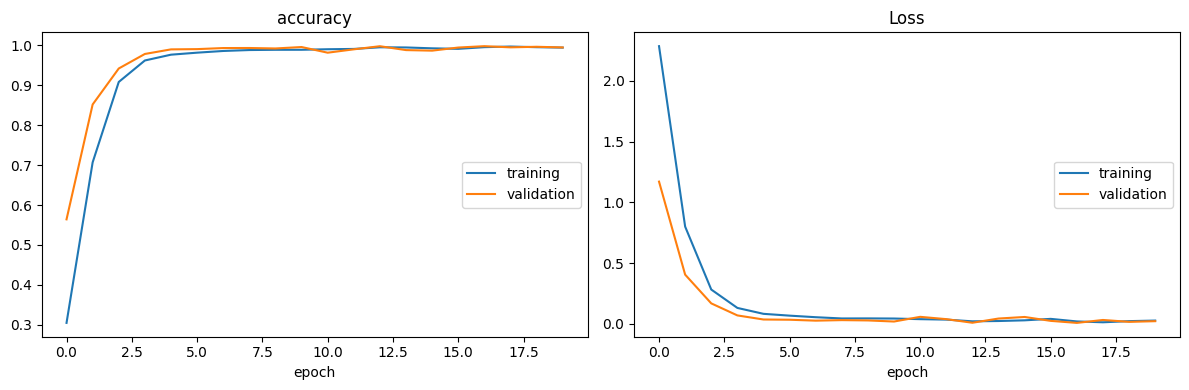

accuracy
	training         	 (min:    0.305, max:    0.997, cur:    0.994)
	validation       	 (min:    0.564, max:    0.997, cur:    0.994)
Loss
	training         	 (min:    0.013, max:    2.286, cur:    0.027)
	validation       	 (min:    0.008, max:    1.171, cur:    0.022)


In [ ]:
main(
    model,
    optimizer,
    DEVICE,
    pin_memory=GPU_AVAILABLE,
    ckpt_dir=CKPT_DIR,
    data_augmentation=True,
)

## 8 Perform Inference

In this section, we will load the best trained model and perform evaluation on both the validation and testing set to compare the difference in metrics.  We will also perform prediction visualization on some validation and test set images.

### 8.1 Load the Trained Model

In [ ]:
DEVICE, _ = get_default_device()

# Loading best model.
trained_model = MyModel(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES)
trained_model.to(DEVICE)

# # Compile mlp_model if model was compiled during training.
# trained_model = torch.compile(trained_model)

trained_model.load_state_dict(torch.load(os.path.join(CKPT_DIR, "ckpt.tar"), map_location=DEVICE)['model'])

trained_model.eval();

### 8.2 Get Valid & Test Dataloader

In [ ]:
# Intialize train and valid dataloaders.
_, valid_loader, test_loader = get_data(
            resize_to = (DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
           batch_size = TrainingConfig.BATCH_SIZE,
          num_workers = TrainingConfig.NUM_WORKERS
)

Number of images :: Training: 31367, Validation: 7842, Testing: 12630


### 8.3 Perform Evaluation Using Trained Model

In [ ]:
evaluate(trained_model, valid_loader, DEVICE, DatasetConfig.NUM_CLASSES, 1, 1)

Valid :: Epoch: 1/1: 100%|##################################| 123/123 [00:01<00:00, 104.98it/s, Loss: 0.0084, Acc: 0.9974]


(0.008373272605240345, 0.9974496364593506)

In [ ]:
evaluate(trained_model, test_loader, DEVICE, DatasetConfig.NUM_CLASSES, 1, 1, validation=False)

Test :: Epoch: 1/1: 100%|###################################| 198/198 [00:01<00:00, 122.41it/s, Loss: 0.0782, Acc: 0.9794]


(0.0782354548573494, 0.9794141054153442)

| **-**        | **Validation** | **Testing** |
|:------------:|:--------------:|:-----------:|
| **Loss**     | 0.0042         | 0.1386      |
| **Accuracy** | 0.9974         | 0.9794      |

The validation and testing loss and accuracy are close to each other, indicating we are on the right track, and the model is quite robust despite its simplicity.

### 8.4 Display Sample Predictions


Here we create a convenience function to plot some sample predictions from both the validation and test datasets. It can be helpful to visually spot-check prediction results. Each displayed image contains a title with the ground truth label (left) and the predicted label (right). If the predicted label is incorrect, the title is displayed in red to highlight the incorrect result.

In [ ]:
def display_predictions(model, loader):

    plt.figure(figsize=(15, 15))
    num_rows = 8
    num_cols = 8
    jdx = 0
    class_names = [str(i) for i in range(DatasetConfig.NUM_CLASSES)]

    # Evaluate two batches.
    for image_batch, labels_batch in loader:

        # Predictions for the current batch.
        with torch.no_grad():
            predictions = model(image_batch.to(DEVICE)).cpu()

        image_batch = denormalize(image_batch, mean=DatasetConfig.MEAN, std=DatasetConfig.STD).permute(0, 2, 3, 1).numpy()

        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
            pred_idx = torch.argmax(predictions[idx]).numpy()
            truth_idx = labels_batch[idx].numpy()

            # Set the title color based on the prediction.
            if pred_idx == truth_idx:
                color = "g"
            else:
                color = "r"

            jdx += 1

            if jdx > num_rows * num_cols:
                # Break from the loops if the maximum number of images have been plotted
                break

            ax = plt.subplot(num_rows, num_cols, jdx)
            title = str(class_names[truth_idx]) + " : " + str(class_names[pred_idx])

            title_obj = plt.title(title)
            plt.setp(title_obj, color=color)
            plt.axis("off")

            plt.imshow(image_batch[idx])
    return

#### 8.4.1 Display Sample Validation Results

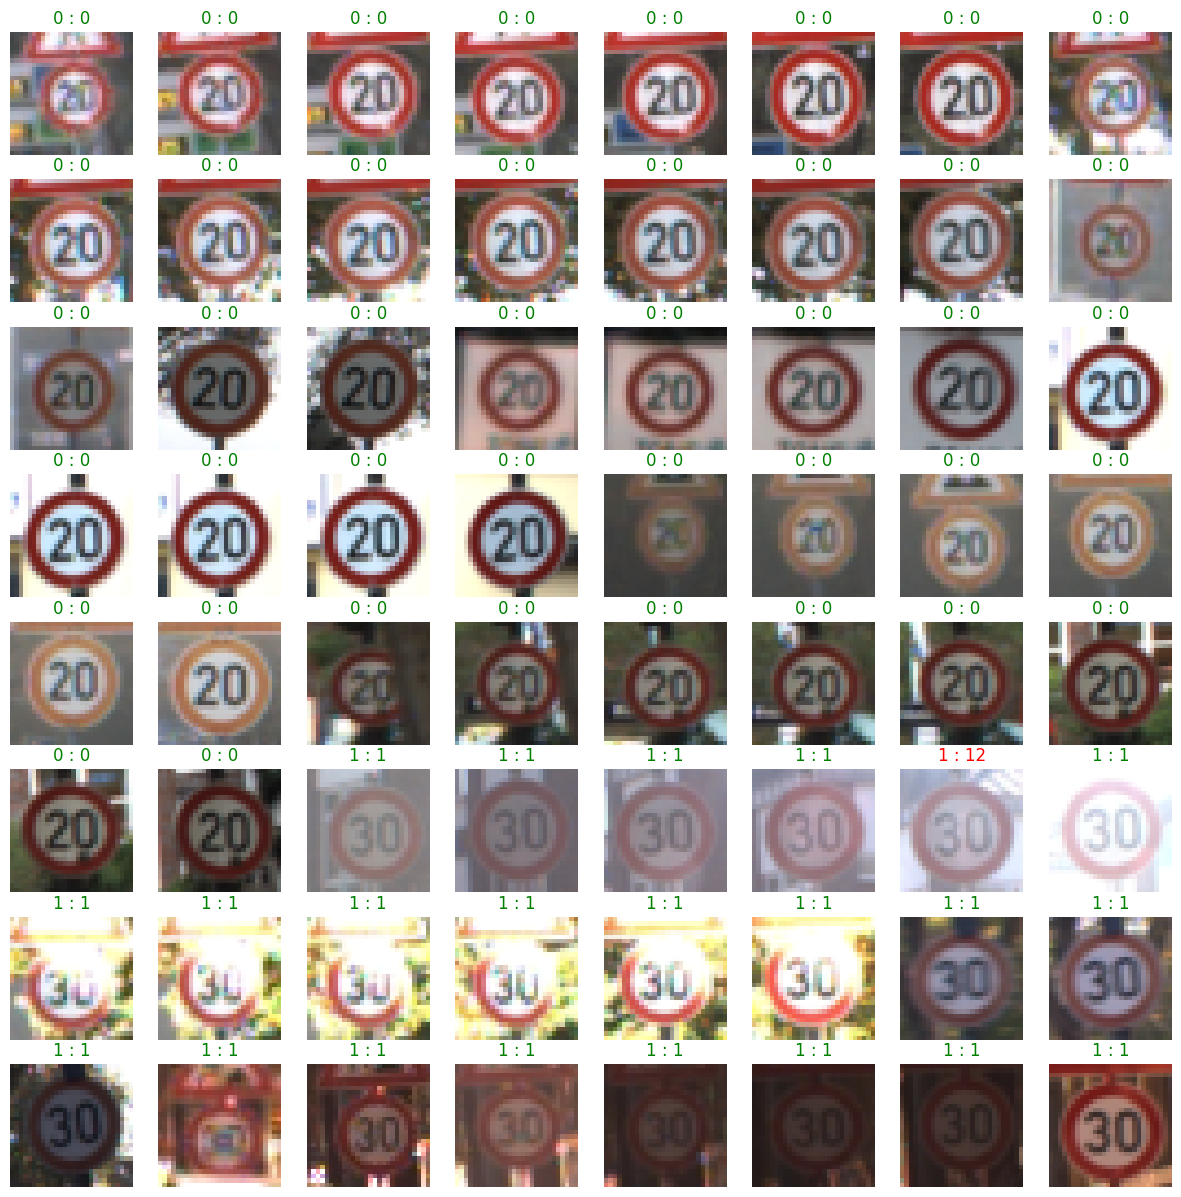

In [ ]:
display_predictions(model, valid_loader)

#### 8.4.2 Display Sample Test Results

Since the testing accuracy is about ≈98%, we might expect a couple of mistakes out of the 64 samples. As you can see below, there are some misclassifications.

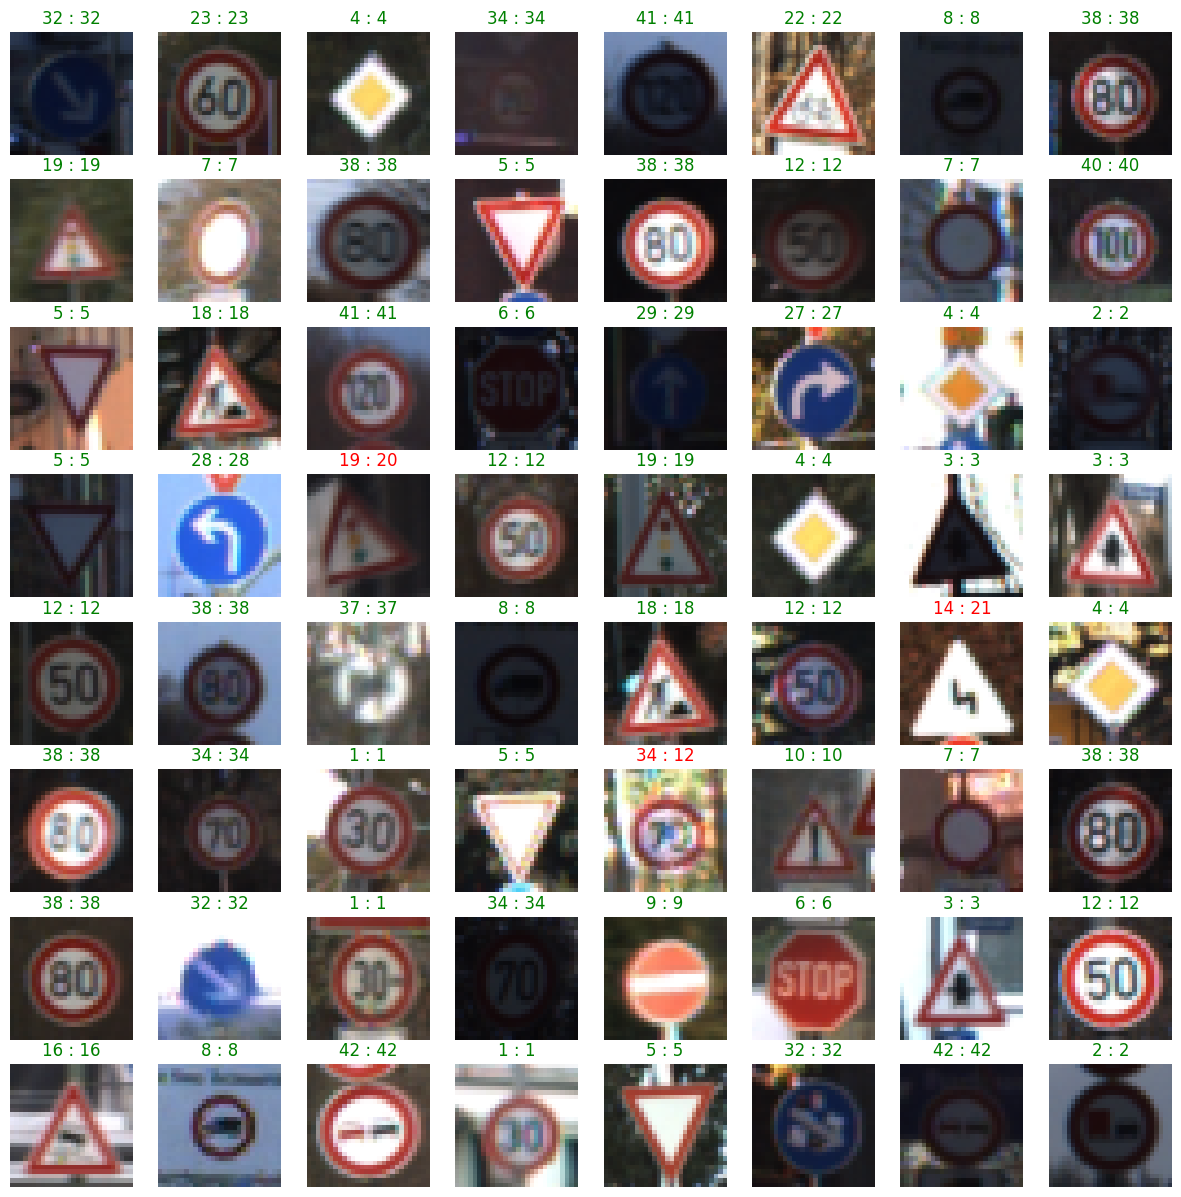

In [ ]:
display_predictions(model, test_loader)

## 9 Conclusion

In this notebook, we introduced image classification using Convolutional Neural Networks (CNNs). We trained it from scratch on the  German Traffic Sign Recognition Benchmark (GTSRB) dataset.

We also introduced how to calculate normalization statistics on dataset present on the disk and how we can leverage the folder structure commonly used for image classification datasets and load it quickly.

In the following units, we will learn how to use readily available classification models pre-trained on a large scale 1000 classes "Imagenet" dataset in torchvision. We will learn how to perform transfer learning and fine-tune pre-trained models to adapt them to a custom dataset.

## Exercise

As an exercise, you can try to achieve 99% accuracy on the test set by changing the model architecture, using different learning rates, or using a learning rate scheduler. As the dataset is imbalanced, you may also use a weighted cross-entropy loss function to weigh the mistakes made on samples of different classes.